In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# CIFAR-10 for ImageNet-style preprocessing for pretrained ResNet
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=8),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

full_train = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfms)
test_ds    = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfms)
class_names = full_train.classes

train_len = int(0.9 * len(full_train))
val_len   = len(full_train) - train_len
train_ds, val_ds = random_split(full_train, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s]


In [3]:
def build_resnet(model_name="resnet18", num_classes=10):
    if model_name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "resnet18":
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    else:
        raise ValueError("Use 'resnet18' or 'resnet50'")

    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

def epoch_pass(model, loader, optimizer=None):
    criterion = nn.CrossEntropyLoss()
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            logits = model(x)
            loss = criterion(logits, y)
            if train_mode:
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        total += y.size(0)
        correct += (pred == y).sum().item()

    return total_loss / len(loader), correct / total

def train_model(model, optimizer, epochs=5):
    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = epoch_pass(model, train_loader, optimizer)
        va_loss, va_acc = epoch_pass(model, val_loader, optimizer=None)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {ep:02d}/{epochs} | "
              f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | "
              f"Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

    model.load_state_dict(best_state)
    return model


In [5]:
@torch.no_grad()
def test_performance(model, label="Model"):
    te_loss, te_acc = epoch_pass(model, test_loader, optimizer=None)
    print(f"{label} | Test Loss {te_loss:.4f} | Test Acc {te_acc:.4f}")
    return te_loss, te_acc

In [6]:
# A) No fine-tuning (train head only)
model_nft = build_resnet("resnet50")

for p in model_nft.parameters():
    p.requires_grad = False
for p in model_nft.fc.parameters():
    p.requires_grad = True

opt_nft = optim.Adam(model_nft.fc.parameters(), lr=1e-3) #learning rate initalized at 0.001, no weight dacay

print("=== No Fine-tuning (train fc only) ===")
model_nft = train_model(model_nft, opt_nft, epochs=5)
nft_loss, nft_acc = test_performance(model_nft, "No Fine-tuning")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


=== No Fine-tuning (train fc only) ===
Epoch 01/5 | Train Loss 0.8643 Acc 0.7226 | Val Loss 0.6133 Acc 0.7962
Epoch 02/5 | Train Loss 0.6249 Acc 0.7874 | Val Loss 0.6195 Acc 0.7878
Epoch 03/5 | Train Loss 0.6014 Acc 0.7919 | Val Loss 0.5513 Acc 0.8092
Epoch 04/5 | Train Loss 0.5894 Acc 0.7956 | Val Loss 0.5495 Acc 0.8138
Epoch 05/5 | Train Loss 0.5765 Acc 0.8006 | Val Loss 0.5718 Acc 0.8034
No Fine-tuning | Test Loss 0.5929 | Test Acc 0.7980


In [7]:
# B) Fine-tuning (unfreeze layer4 + fc)
model_ft = build_resnet("resnet18")

# freeze all
for p in model_ft.parameters():
    p.requires_grad = False

# unfreeze last stage + head
for p in model_ft.layer4.parameters():
    p.requires_grad = True
for p in model_ft.fc.parameters():
    p.requires_grad = True

# discriminative LRs
opt_ft = optim.Adam([
    {"params": model_ft.layer4.parameters(), "lr": 1e-5},
    {"params": model_ft.fc.parameters(),     "lr": 1e-4},
], weight_decay=1e-4)

print("\n=== Fine-tuning (layer4 + fc) ===")
model_ft = train_model(model_ft, opt_ft, epochs=5)
ft_loss, ft_acc = test_performance(model_ft, "Fine-tuned")

print("\nComparison:")
print(f"No Fine-tuning: Loss {nft_loss:.4f}, Acc {nft_acc:.4f}")
print(f"Fine-tuned    : Loss {ft_loss:.4f}, Acc {ft_acc:.4f}")


=== Fine-tuning (layer4 + fc) ===
Epoch 01/5 | Train Loss 0.8627 Acc 0.7384 | Val Loss 0.4634 Acc 0.8516
Epoch 02/5 | Train Loss 0.4119 Acc 0.8631 | Val Loss 0.3412 Acc 0.8856
Epoch 03/5 | Train Loss 0.3313 Acc 0.8889 | Val Loss 0.3069 Acc 0.8950
Epoch 04/5 | Train Loss 0.2853 Acc 0.9040 | Val Loss 0.2705 Acc 0.9050
Epoch 05/5 | Train Loss 0.2536 Acc 0.9137 | Val Loss 0.2547 Acc 0.9104
Fine-tuned | Test Loss 0.2752 | Test Acc 0.9063

Comparison:
No Fine-tuning: Loss 0.5929, Acc 0.7980
Fine-tuned    : Loss 0.2752, Acc 0.9063


In [15]:
#Visualizing the feature maps of the model
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def get_feature_maps(model, layer_module, x):
    model.eval()
    out = {}

    def hook_fn(m, inp, output):
        out["feat"] = output.detach().cpu()

    h = layer_module.register_forward_hook(hook_fn)
    _ = model(x)   # forward triggers hook
    h.remove()

    return out["feat"]  # typically (B, C, H, W)

def show_feature_maps(feat, title, k=16, figsize=(6, 6)):
    fm = feat[0]  # (C, H, W)
    k = min(k, fm.shape[0])

    cols = 4
    rows = (k + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i in range(k):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(fm[i], cmap="gray")
        plt.axis("off")

    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

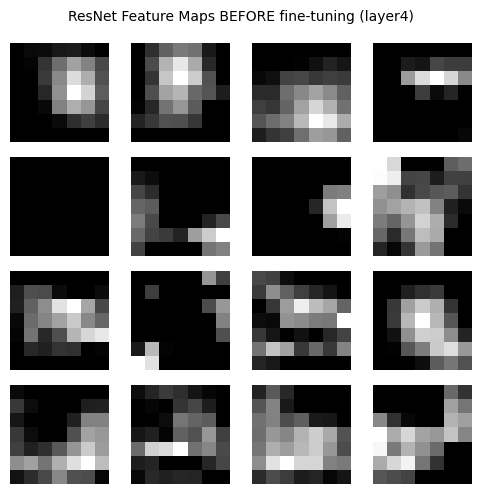

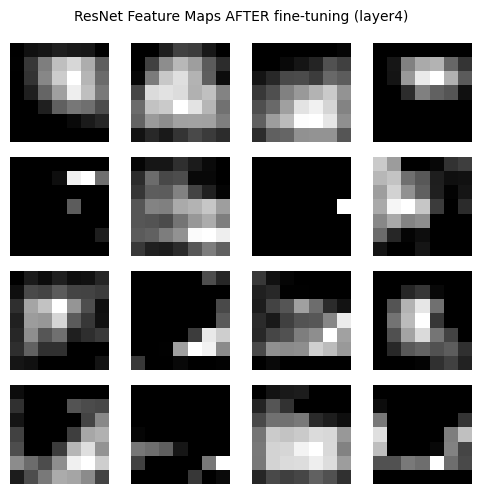

In [16]:
show_feature_maps(
    feat_before,
    "ResNet Feature Maps BEFORE fine-tuning (layer4)",
    k=16,
    figsize=(5, 5)
)

show_feature_maps(
    feat_after,
    "ResNet Feature Maps AFTER fine-tuning (layer4)",
    k=16,
    figsize=(5, 5)
)
